In [3]:
import requests
from bs4 import BeautifulSoup

import pandas as pd
import numpy as np
import time

import seaborn
from matplotlib import pyplot

from sklearn.linear_model import LogisticRegression

%load_ext sql

%config SqlMagic.autopandas = True
%config SqlMagic.feedback = False
%config SqlMagic.displaycon = False

%sql duckdb:///:memory:

In [4]:
#Importing chess games cleaned csv file
chess_games = pd.read_csv('chess_games_cleaned.csv')
chess_games = chess_games.iloc[:,1:]
print(display(chess_games))

,Result,WhiteElo,BlackElo,WhiteRatingDiff,ECO,Opening,TimeControl,Termination,Base (min),Increment (sec)
0,1-0,1901,1896,5,D10,Slav Defense,300+5,Time forfeit,5.0,5
1,0-1,1641,1627,14,C20,King's Pawn Opening: 2.b3,300+0,Normal,5.0,0
2,1-0,1647,1688,-41,B01,Scandinavian Defense: Mieses-Kotroc Variation,180+0,Time forfeit,3.0,0
3,0-1,1945,1900,45,B90,"Sicilian Defense: Najdorf, Lipnitsky Attack",180+0,Time forfeit,3.0,0
4,0-1,1773,1809,-36,C27,Vienna Game,180+0,Normal,3.0,0
...,...,...,...,...,...,...,...,...,...,...
621597,0-1,1798,1753,45,B06,Modern Defense,60+0,Time forfeit,1.0,0
621598,0-1,1711,1578,133,B08,Pirc Defense: Classical Variation,300+0,Normal,5.0,0
621599,1-0,1762,1683,79,C00,St. George Defense,300+4,Normal,5.0,4
621600,1-0,2023,1742,281,A45,Indian Game,180+0,Normal,3.0,0


None


In [5]:
#Summary Statistics and Descriptive Statistics
print(display(chess_games.describe()))

,WhiteElo,BlackElo,WhiteRatingDiff,Base (min),Increment (sec)
count,621602.00000,621602.000000,621602.000000,621602.000000,621602.000000
mean,1744.71923,1743.194322,1.524908,5.262102,1.200263
std,264.41478,265.945593,202.275038,6.636483,4.159350
min,784.00000,728.000000,-1569.000000,0.000000,0.000000
25%,1563.00000,1560.000000,-104.000000,2.000000,0.000000
50%,1745.00000,1743.000000,1.000000,4.000000,0.000000
75%,1922.00000,1922.000000,107.000000,6.000000,1.000000
max,3006.00000,3069.000000,1469.000000,180.000000,180.000000


None


Returning data to local variable top_ten_popular_openings
Returning data to local variable top_ten_won_openings


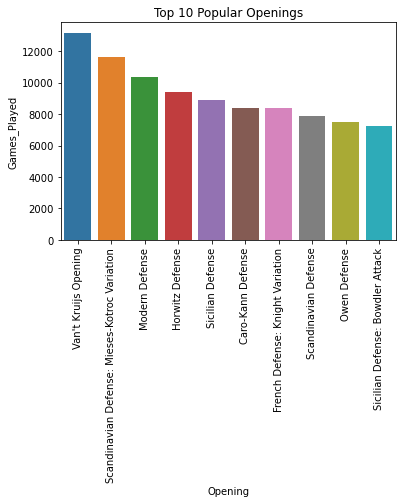

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'Scandinavian Defense: Mieses-Kotroc Variation'),
  Text(1, 0, "Van't Kruijs Opening"),
  Text(2, 0, 'Modern Defense'),
  Text(3, 0, 'Horwitz Defense'),
  Text(4, 0, 'French Defense: Knight Variation'),
  Text(5, 0, 'Owen Defense'),
  Text(6, 0, 'Caro-Kann Defense'),
  Text(7, 0, 'Scandinavian Defense'),
  Text(8, 0, 'Sicilian Defense'),
  Text(9, 0, 'Philidor Defense #3')])

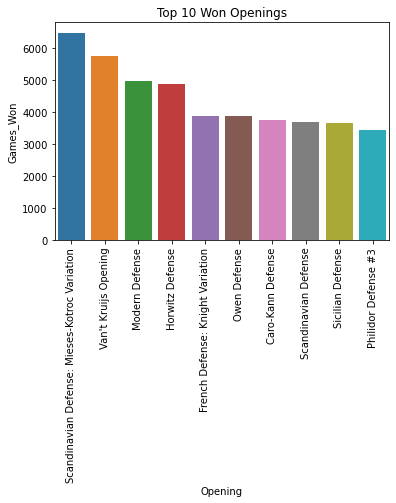

In [9]:
#Top 10 popular openings & top 10 won openings
%sql top_ten_popular_openings << SELECT Opening, COUNT(ECO) As Games_Played \
FROM chess_games GROUP BY Opening ORDER BY Games_Played DESC LIMIT 10
%sql top_ten_won_openings << SELECT Opening, COUNT(ECO) AS Games_Won \
FROM chess_games WHERE Result = '1-0' GROUP BY Opening ORDER BY Games_Won DESC LIMIT 10

#plotting the top 
seaborn.barplot(data = top_ten_popular_openings, x = 'Opening', y = 'Games_Played').set(title = 'Top 10 Popular Openings')
pyplot.xticks(rotation = 90)
pyplot.show()
seaborn.barplot(data = top_ten_won_openings, x = 'Opening', y = 'Games_Won').set(title = 'Top 10 Won Openings')
pyplot.xticks(rotation = 90)

In [11]:
#adding win rate column for each opening

#all openings with corresponding number of games played
%sql opening_games_played << SELECT Opening, COUNT(ECO) As Games_Played \
FROM chess_games GROUP BY Opening ORDER BY Games_Played DESC

print(opening_games_played)

#all openings with corresponding number of games won
%sql opening_games_won << SELECT Opening, COUNT(ECO) AS Games_Won \
FROM chess_games WHERE Result = '1-0' GROUP BY Opening ORDER BY Games_Won DESC

print(opening_games_won)

#joining games played and games won by opening
%sql opening_games << SELECT opening_games_played.Opening, Games_Played, Games_Won \
FROM opening_games_played LEFT JOIN opening_games_won \
ON opening_games_played.Opening = opening_games_won.Opening ORDER BY Games_Played DESC

#drop NaNs --> NaNs in Games_Won column indicate that opening has 0 games won
opening_games.dropna()

#filter for openings that have at least 50 games played
opening_games = opening_games[opening_games['Games_Played'] >= 50]

#compute win rate column and sort by win rate
opening_games['Win_Rate'] = opening_games['Games_Won'] / opening_games['Games_Played']
opening_win_rate = opening_games.sort_values(by = ['Win_Rate'], ascending = False)

#drop columns Games_Played and Games_Won; rename Opening to Opening_Type for later merging
opening_win_rate = opening_win_rate.drop(columns = ['Games_Played', 'Games_Won'])
opening_win_rate = opening_win_rate.rename(columns={'Opening': 'Opening_Type'})

display(opening_win_rate)

Returning data to local variable opening_games_played
                                                Opening  Games_Played
0                                  Van't Kruijs Opening         13161
1         Scandinavian Defense: Mieses-Kotroc Variation         11615
2                                        Modern Defense         10334
3                                       Horwitz Defense          9408
4                                      Sicilian Defense          8881
...                                                 ...           ...
2618                         Bird Opening: Platz Gambit             1
2619                 Dutch Defense: Stonewall Variation             1
2620                    Dutch Defense: Bladel Variation             1
2621  Sicilian Defense: Dragon Variation, Classical ...             1
2622       Pterodactyl Defense: Sicilian, Benoni Gambit             1

[2623 rows x 2 columns]
Returning data to local variable opening_games_won
                              

,Opening_Type,Win_Rate
614,"Italian Game: Two Knights Defense, Knight Attack",0.790850
932,Indian Game: Normal Variation,0.772727
737,"Italian Game: Two Knights Defense, Max Lange A...",0.735849
946,Scandinavian Defense: Anderssen Counterattack,0.734375
880,Italian Game: Scotch Gambit Declined,0.733333
...,...,...
1048,Nimzowitsch Defense: Scandinavian Variation,0.326923
685,"Queen's Pawn Opening: Veresov, Richter Attack",0.322314
70,King's Pawn Game,0.321090
805,"Sicilian Defense: Sozin Attack, Leonhardt Vari...",0.311111


In [22]:
#adding win rate to individual games data frame
%sql chess_games_rate << SELECT * FROM chess_games INNER JOIN opening_win_rate \
ON chess_games.Opening = opening_win_rate.Opening_Type

chess_games_rate = chess_games_rate.drop(columns = ['Opening_Type'])
display(chess_games_rate)

Returning data to local variable chess_games_rate


,Result,WhiteElo,BlackElo,WhiteRatingDiff,ECO,Opening,TimeControl,Termination,Base (min),Increment (sec),Win_Rate
0,1-0,1901,1896,5,D10,Slav Defense,300+5,Time forfeit,5.0,5,0.490376
1,0-1,1641,1627,14,C20,King's Pawn Opening: 2.b3,300+0,Normal,5.0,0,0.412060
2,1-0,1647,1688,-41,B01,Scandinavian Defense: Mieses-Kotroc Variation,180+0,Time forfeit,3.0,0,0.558588
3,0-1,1945,1900,45,B90,"Sicilian Defense: Najdorf, Lipnitsky Attack",180+0,Time forfeit,3.0,0,0.444695
4,0-1,1773,1809,-36,C27,Vienna Game,180+0,Normal,3.0,0,0.579278
...,...,...,...,...,...,...,...,...,...,...,...
601612,0-1,1798,1753,45,B06,Modern Defense,60+0,Time forfeit,1.0,0,0.480550
601613,0-1,1711,1578,133,B08,Pirc Defense: Classical Variation,300+0,Normal,5.0,0,0.457798
601614,1-0,1762,1683,79,C00,St. George Defense,300+4,Normal,5.0,4,0.539982
601615,1-0,2023,1742,281,A45,Indian Game,180+0,Normal,3.0,0,0.450352


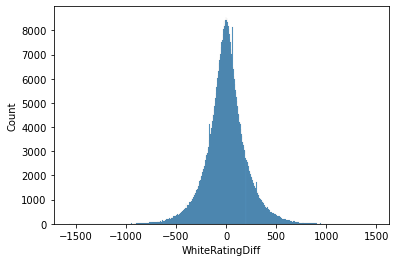

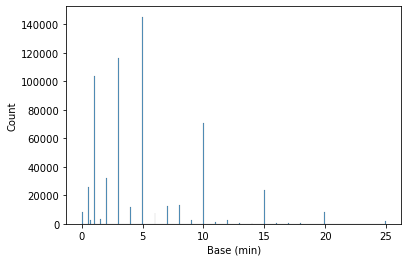

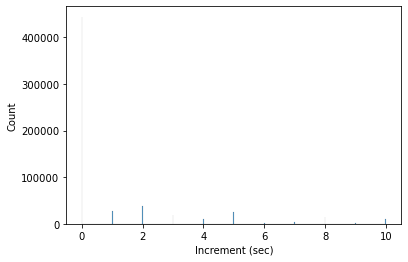

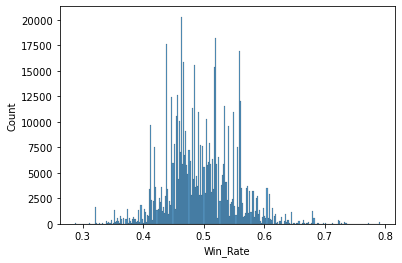

In [34]:
#histograms to help us see distributions of rating differential, time control variables, and win rate
seaborn.histplot(data = chess_games_rate, x = 'WhiteRatingDiff')
pyplot.show()
seaborn.histplot(data = chess_games_rate, x = 'Base (min)', binrange = (0,25))
pyplot.show()
seaborn.histplot(data = chess_games_rate, x = 'Increment (sec)', binrange = (0,10))
pyplot.show()
seaborn.histplot(data = chess_games_rate, x = 'Win_Rate')
pyplot.show()

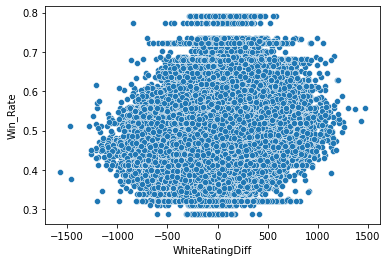

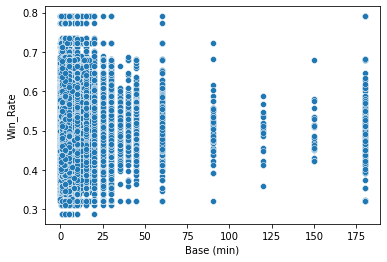

In [35]:
#scatterplots to see relationship between rating differential and win rate vs. base time control and win rate
seaborn.scatterplot(data = chess_games_rate, x = 'WhiteRatingDiff', y = 'Win_Rate')
pyplot.show()
seaborn.scatterplot(data = chess_games_rate, x = 'Base (min)', y = 'Win_Rate')
pyplot.show()

In [36]:
#correlation between Elo rating differential and win rate
display(chess_games_rate[['WhiteRatingDiff','Win_Rate']].corr())

#covariance between Elo rating differential and win rate
display(chess_games_rate[['WhiteRatingDiff', 'Win_Rate']].cov())

,WhiteRatingDiff,Win_Rate
WhiteRatingDiff,1.000000,0.161568
Win_Rate,0.161568,1.000000


,WhiteRatingDiff,Win_Rate
WhiteRatingDiff,41011.116532,1.849207
Win_Rate,1.849207,0.003194
